# Tarea 3 parte 2

    SELECT gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
    
De los catálogos se toman las magnitudes aparentes observadas y los paralajes para luego transformarlas a absolutas, es interesante notar que dentro del mismo query se puede llevar ecuaciones simples y obtener los resultados de estas como datos del catalogo.   
    
    hip."B-V"
El valor fotométrico B-V.
    
    
    FROM "I/337/tgas" AS gaia
    INNER JOIN "I/311/hip2" as hip

Se le da un nombre (alias) a los catalogos de GAIA e Hiparcos 2.
    
    
    ON gaia.hip = hip.HIP
Se hace un match entre los dos catalogos.
    
    WHERE gaia.parallax/gaia.parallax_error >= 5 AND
        hip.Plx/hip.e_Plx >= 5 AND
    
        hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
    
        (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
        
Finalmente se aplican 4 criterios para los datos obtenidos, de este modo se puede asegurar que se tendrán los mejores datos posibles dentro del total. Se flitra por señal a ruido del paralaje de gaia e hipparcos (S/N>=5), errores de B-V dentro de 0,0.05 y también por el flujo y su error. 

Entonces haciendo el query utilizando el codgio act4.py dado:

In [1]:
import act4 as act

tap_endpoint = 'http://tapvizier.u-strasbg.fr/TAPVizieR/tap'

adql_query = """ SELECT gaia.source_id, gaia.hip,
gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
hip."B-V"
FROM "I/337/tgas" AS gaia
INNER JOIN "I/311/hip2" as hip
ON gaia.hip = hip.HIP
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
hip.Plx/hip.e_Plx >= 5 AND
hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
(2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05 """

datos=act.query_TAP(tap_endpoint,adql_query)

/home/zapredfield/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


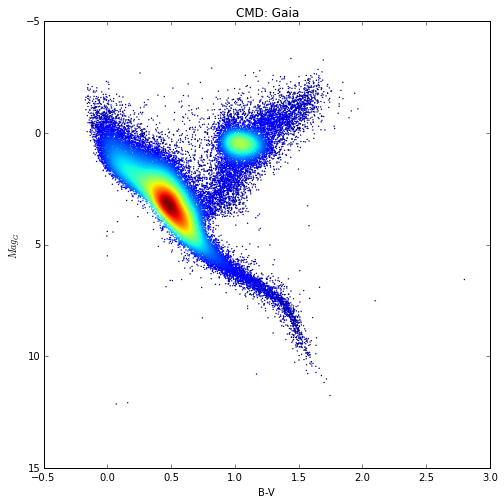

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

act.plot_scatter_density(datos, "B-V", "g_mag_abs_gaia", "B-V", "$Mag_G$", "CMD: Gaia")

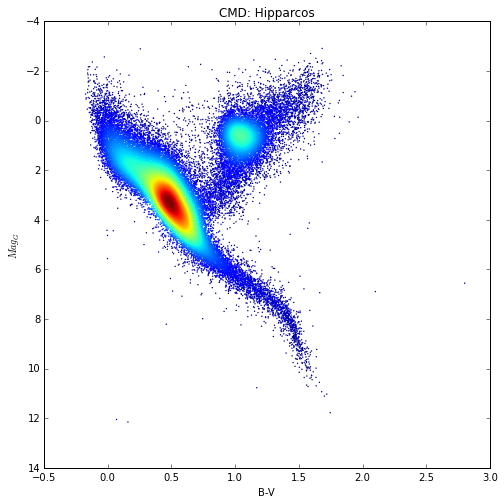

In [3]:
act.plot_scatter_density(datos, "B-V", "g_mag_abs_hip", "B-V", "$Mag_G$", "CMD: Hipparcos")

2.
  
  Sloan Digital Sky Survey (SDSS) tiene como meta obtener datos fotométricos y espectros tanto de estrellas como galaxias para luego catalogar los resultados. Actualmente ha analizado un 35% del cielo. Las galaxias en su mayoria estan a redshifts "bajos" cerca de z=0.1, a exepción de quasares.
    
  La obtención de espectros es sumamente relevante ya que es la forma más completa de entender las galaxias/estrellas. 

Al hacer el query dado se obtienen los datos en un archivo .fit, el cual analizamos a continuación. Los datos pedidos son del DR8.

DR se refiere a Data Release, luego de cierto tiempo cuando son obtenidos suficientes datos se liberan catálogos al público, cada catalogo sucesivo contiene nuevos datos (espectros en su mayoria) y revisiones de observaciones previas.

Para este query se uso Data Release 8 fecha Enero 2011, el cual contiene fotometría de 14.000 grados cuadrados del cielo y los espectros obtenidos durante el año previo.

Respecto al query:



    SELECT

Aqui estan los datos que deseamos obtener en nuestro catalogo, notar que son los mismos dados en el header más abajo. Entonces en orden se piden: 

    G.ra, G.dec, S.mjd, S.plate, S.fiberID,
    S.z, S.zErr, S.rChi2, S.velDisp, S.velDispErr,
Ascensión y Declinación, fecha de observación en dias julianos, la placa utilizada para obtener el espectro, Id de la fibra asignada al objeto, redshift y su error, indice chi cuadrado para el fit al mejor template, velocidad de dispersión y su error (galaxias).
    
    G.extinction_r, G.petroMag_r, G.psfMag_r, G.psfMagErr_r,
    G.modelMag_u, G.modelMagErr_u, G.modelMag_g, G.modelMagErr_g,
    G.modelMag_r, G.modelMagErr_r, G.modelMag_i, G.modelMagErr_i,
    G.modelMag_z, G.modelMagErr_z, G.petroR50_r, G.petroR90_r,
    
Extinción, magnitud petrosian (método para obtener magnitud de galaxias), magnitud de psfy su error, magnitudes y errores de bandas u,g,r,i,z y magnitudes petrosianas encerrando 50% de la luz y 90%.
    
    
    
    GSL.nii_6584_flux, GSL.nii_6584_flux_err, GSL.h_alpha_flux,
    GSL.h_alpha_flux_err, GSL.oiii_5007_flux, GSL.oiii_5007_flux_err,
    GSL.h_beta_flux, GSL.h_beta_flux_err, GSL.h_delta_flux, GSL.h_delta_flux_err,

Flujos y errores de las lineas NII, $H_\alpha$, OIII , $H_\beta$ y $H_\delta$
    
    

    GSX.d4000, GSX.d4000_err, GSE.bptclass,
    GSE.lgm_tot_p50, GSE.sfr_tot_p50, G.objID, GSI.specObjID

d4000 tiene que ver con el break de los 4000$A$, lgm es el logaritmo de la masa, sfr es la tasa de formacion estelar $log(M_o/yr)$ y por último las ID del obejto y de su espectro.

 
    INTO mydb.SDSS FROM SpecObj S CROSS APPLY

        dbo.fGetNearestObjEQ(S.ra, S.dec, 0.06) N, Galaxy G,
        GalSpecInfo GSI, GalSpecLine GSL, GalSpecIndx GSX,
        GalSpecExtra GSE

Este comando sirve para la descarga del catalogo.  
    

Por último se aplican criterios para los objetos que se desean, de modo de eliminar objetos no deseados, vemos que lo principal es limitar el rango en que estan las distintas magnitudes. Dar un tope minimo al redshift y limitar el error de este.

    WHERE N.objID = G.objID

    AND GSI.specObjID = S.specObjID

    AND GSL.specObjID = S.specObjID

    AND GSX.specObjID = S.specObjID

    AND GSE.specObjID = S.specObjID

    AND (G.petroMag_r > 10 AND G.petroMag_r < 18)

    AND (G.modelMag_u - G.modelMag_r) > 0

    AND (G.modelMag_u - G.modelMag_r) < 6

    AND (modelMag_u > 10 AND modelMag_u < 25)

    AND (modelMag_g > 10 AND modelMag_g < 25)

    AND (modelMag_r > 10 AND modelMag_r < 25)

    AND (modelMag_i > 10 AND modelMag_i < 25)

    AND (modelMag_z > 10 AND modelMag_z < 25)

    AND S.rChi2 < 2

    AND (S.zErr > 0 AND S.zErr < 0.01)

    AND S.z > 0.02

In [4]:
from astropy.io import fits

In [5]:
hdulist = fits.open('SDSS.fit')

In [6]:
hdulist.info() #vemos las distintas extensiones, en este caso solo una tiene datos utiles

Filename: SDSS.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU    100   661598R x 43C   [1D, 1D, 1J, 1I, 1I, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 1K, 1K]   


In [7]:
head=hdulist[1].header #El header indica los elementos presentes en el catálogo
sc = hdulist[1].data

head

XTENSION= 'BINTABLE'                                                            
BITPIX  =                    8                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  182                                                  
NAXIS2  =               661598                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   43                                                  
TFORM1  = '1D'                                                                  
TTYPE1  = 'ra'                                                                  
TTYPE2  = 'dec'                                                                 
TFORM2  = '1D'                                                                  
TTYPE3  = 'mjd'             

El siguiente paso es crear un diagrama BPT, a continuación un ejemplo de diagrama: 

![title](BPT1.png)

Este diagrama consiste en dar al eje X los valores del logaritmo de la división entre los flujos de las lineas NII y $H_\alpha$, para el eje Y lo mismo pero para OIII y $H_\beta$. 

Al hacer esto el resultado generá una delimitación entre las galaxias con nucleos activos (AGN) y galaxias con alta formación estelar (HII , hidrogeno ionizado). De forma general, las galaxias del cúmulo inferior son de tipo HII y del superior AGN.

In [27]:
#Obtenemos los flujos necesarios y sus errores

n2=sc["nii_6584_flux"]
n2e=sc["nii_6584_flux_err"]
ha=sc["h_alpha_flux"]
hae=sc["h_alpha_flux_err"]
o3=sc["oiii_5007_flux"]
o3e=sc["oiii_5007_flux_err"]
hb=sc["h_beta_flux"]
hbe=sc["h_beta_flux_err"]

Para obtener los mejores resultados posibles filtramos los datos respecto a su signal/noise, nos quedamos solo con objetos con una razón mayor a 10 para todos los flujos.

In [28]:
x=[]
y=[]
SN=10
for i in range(0,len(n2)):
    if ha[i]!=0 and hb[i]!=0 and n2[i]/n2e[i]>SN and ha[i]/hae[i]>SN and o3[i]/o3e[i]>SN and hb[i]/hbe[i]>SN: #Se eliminan 0s y se filtra por señal a ruido
        x.append(n2[i]/ha[i])
        y.append(o3[i]/hb[i])

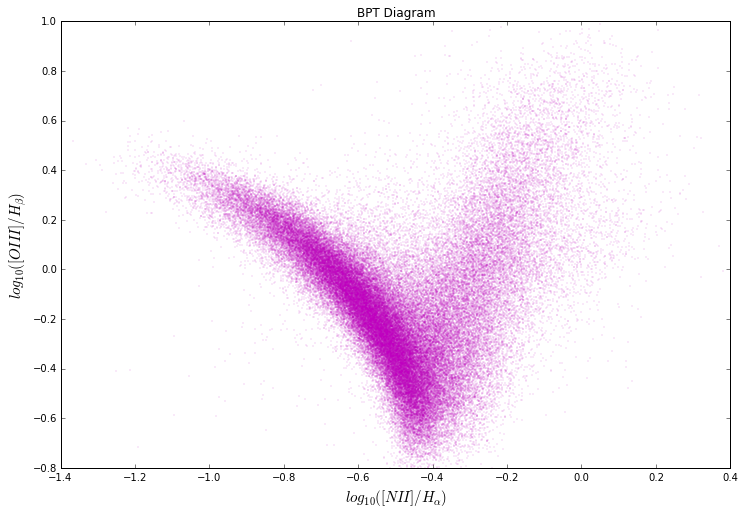

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.xlabel("$log_{10}([NII]/H_{\\alpha})$",size=15)
plt.ylabel("$log_{10}([OIII]/H_{\\beta})$",size=15)
plt.plot(np.log10(x),np.log10(y),".m",ms=2,alpha=0.15)
plt.ylim(-0.8,1)
plt.title("BPT Diagram")
plt.show()

A continuación se veran los espectros de una galaxia HII y una AGN, para ello simplemente tomamos una de cada zona respectiva.

In [11]:
from astroquery.sdss import SDSS as ast
import numpy as np

/home/zapredfield/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [12]:
HIIs=[]
AGNs=[]
pl=sc["plate"]
mj=sc["mjd"]
fid=sc["fiberID"]


SN=10
for i in range(0,len(n2)):

    if ha[i]!=0 and hb[i]!=0 and n2[i]/n2e[i]>SN and ha[i]/hae[i]>SN and o3[i]/o3e[i]>SN and hb[i]/hbe[i]>SN:
        x1=np.log10(n2[i]/ha[i])
        y1=np.log10(o3[i]/hb[i])
        if x1<-0.4 and x1>-0.6 and y1>-0.4 and y1<-0.2:
            HIIs.append((pl[i],mj[i],fid[i],x1,y1))
        if x1<-0.2 and x1>-0.3 and y1>0 and y1<0.2:
            AGNs.append((pl[i],mj[i],fid[i],x1,y1))    

Las galaxias que se tomarán estan en las siguientes posiciones del diagrama, una en la zona HII y otra en la zona AGN.

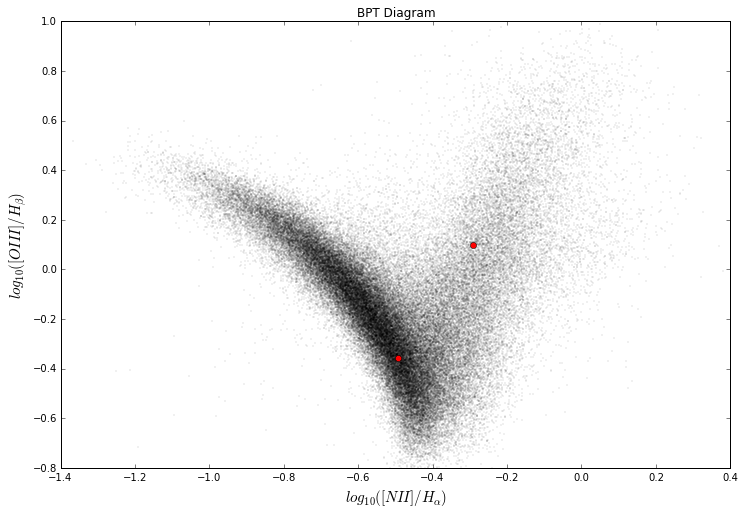

In [13]:
plt.xlabel("$log_{10}([NII]/H_{\\alpha})$",size=15)
plt.ylabel("$log_{10}([OIII]/H_{\\beta})$",size=15)
plt.plot(np.log10(x),np.log10(y),".k",ms=2,alpha=0.1)
plt.plot(-0.49220419, -0.35657287,"or")
plt.plot(-0.29226285, 0.098974943,"or")
plt.ylim(-0.8,1)
plt.title("BPT Diagram")
plt.show()

In [14]:
print HIIs[100]
print AGNs[50]
#plate,mjd,fiberID,posicion X, posicion Y

(299, 51671, 349, -0.49220419, -0.35657287)
(446, 51899, 17, -0.29226285, 0.098974943)


Con la función get_spectra solo se necesita plate,mjd y fiberID, ya descritos en un comienzo.

In [15]:
#Cargando los espectros:
HII=ast.get_spectra(plate=HIIs[100][0],mjd=HIIs[100][1],fiberID=HIIs[100][2])
AGN=ast.get_spectra(plate=AGNs[50][0],mjd=AGNs[50][1],fiberID=AGNs[50][2])

In [16]:
hdulist=HII[0]

Para esta sección no funciona directamente el método de obtener espectros de la tercera parte, luego analizando los headers vemos que los parametros necesarios estan en diferentes lugares, luego se modifica la función acorde a esto:

In [17]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4464397633.31 / 1st row - Number of seconds since Nov 17 1858  
RA      =            205.35711 / 1st row - Right ascension of telescope boresigh
DEC     =            0.005973  / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '05:52:02.36'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                51671 / MJD of observation                             
MJDLIST = '51671   '        

In [18]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 3822 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [19]:
def spectra(result):
    hdulist=result[0]
    c0 = hdulist[0].header['coeff0']
    c1 = hdulist[0].header['coeff1']
    npix = hdulist[1].header['naxis2']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdulist[1].data['flux']
    return wave,flux


In [20]:
x1,y1=spectra(HII)
x2,y2=spectra(AGN)

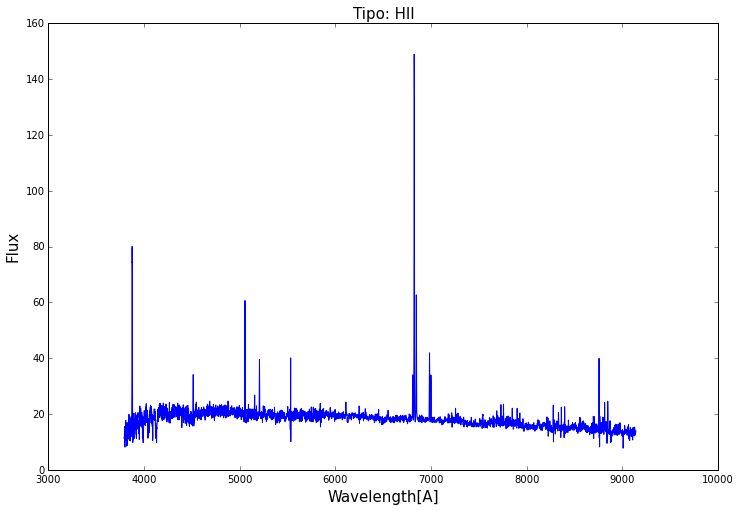

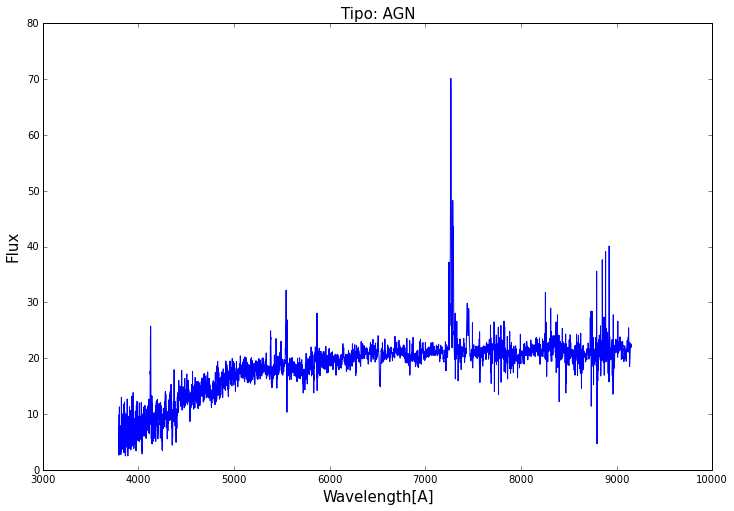

In [21]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(x1,y1)
plt.title("Tipo: HII",size=15)
plt.xlabel("Wavelength[A]",size=15)
plt.ylabel("Flux",size=15)
plt.show()
plt.plot(x2,y2)
plt.title("Tipo: AGN",size=15)
plt.xlabel("Wavelength[A]",size=15)
plt.ylabel("Flux",size=15)
plt.show()

Parte 3

A continuación se mostraran templates de galaxias y estrellas obtenidas por astroquery.sdss. Estos fueron obtenidos con el código entregado. 

Los templates son espectros tipicos de cuerpos celestes que se usan a modo de referencia. Por ejemplo se tiene el espectro que se esperaria de una estrella tipo O o una galaxia temprana.

In [22]:
from astroquery.sdss import SDSS

In [23]:
print SDSS.AVAILABLE_TEMPLATES

{u'star_L1': 15, u'star_FA': 5, u'galaxy': [24, 25, 26], u'star_G': [8, 9], u'star_F': [6, 7], u'star_OB': 1, u'galaxy_lrg': 28, u'galaxy_late': 27, u'star_M5': 13, u'star_M3': 12, u'star_M1': 11, u'galaxy_early': 23, u'qso': 29, u'star_M8': 14, u'star_K': 10, u'star_O': 0, u'star_B': 2, u'star_A': [3, 4], u'star_carbon': [17, 18, 19], u'qso_bal': [30, 31], u'star_wd': [16, 20, 21], u'qso_bright': 32, u'star_Ksubdwarf': 22}


In [24]:
names=["galaxy","galaxy_lrg","galaxy_late","galaxy_early","qso","qso_bal","qso_bright","star_L1","star_FA","star_G","star_F","star_OB","star_M5","star_M3","star_M1","star_M8","star_K","star_O","star_B","star_A","star_carbon","star_wd","star_Ksubdwarf"]
result=[]
for i in names:
    result.append(SDSS.get_spectral_template(i))


In [25]:
import numpy as np

def templ(result):
    hdulist=result[0]
    c0 = hdulist[0].header['coeff0']
    c1 = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))
    flux = hdulist[0].data[0,:]
    return wave,flux

Algunas de lineas de abosrción y emisión importantes serán marcadas con lineas entrecortadas. Estas fueron obtenidas de:

En negro: (http://skyserver.sdss.org/dr1/en/proj/advanced/spectraltypes/lines.asp)

En rojo:(http://classic.sdss.org/dr6/algorithms/linestable.html)

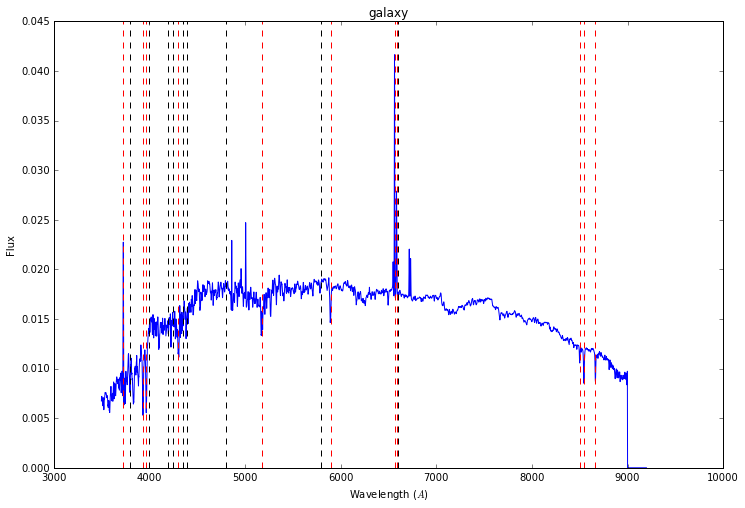

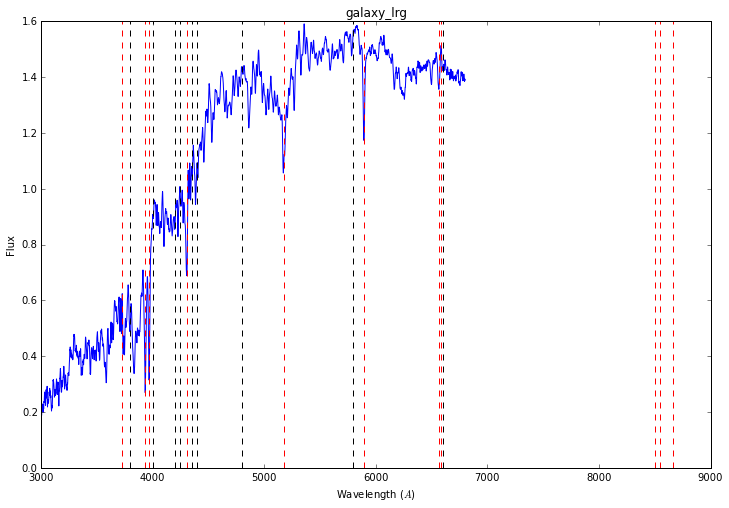

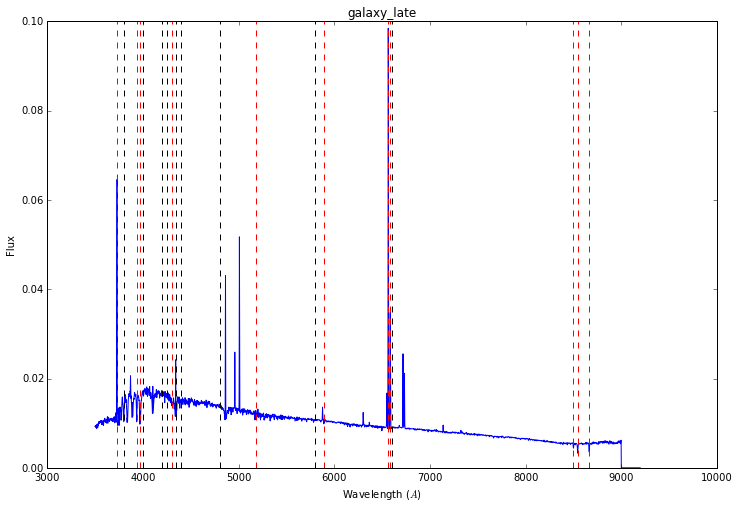

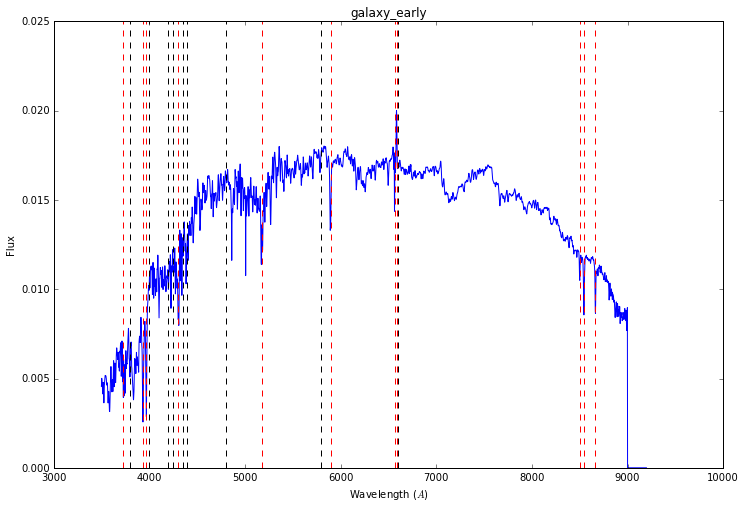

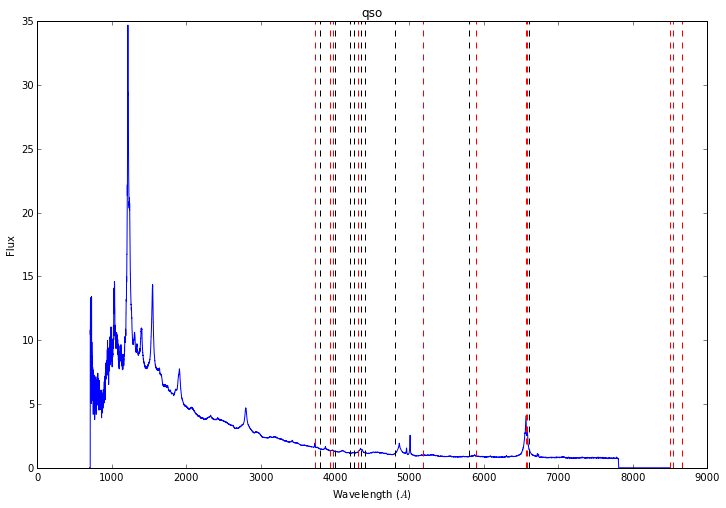

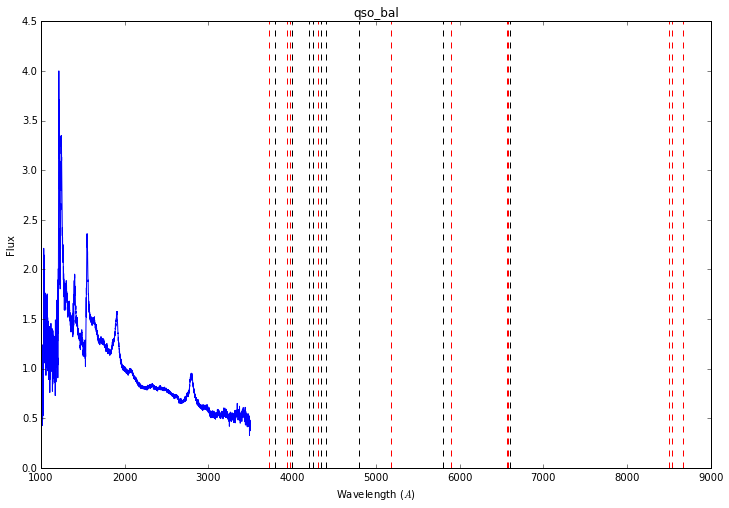

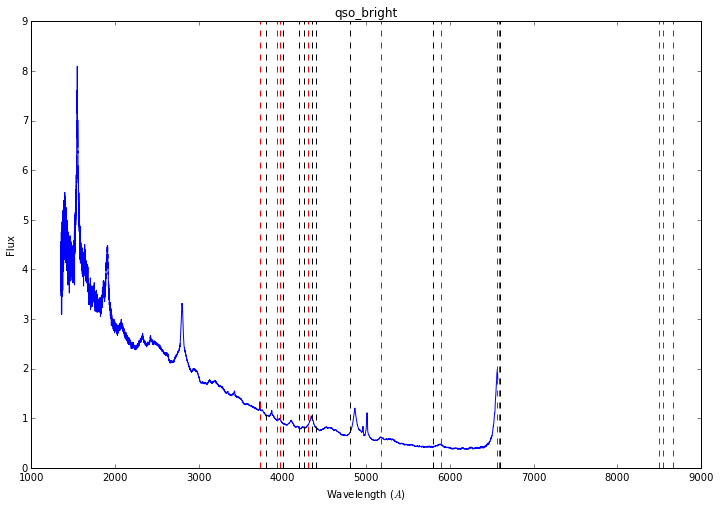

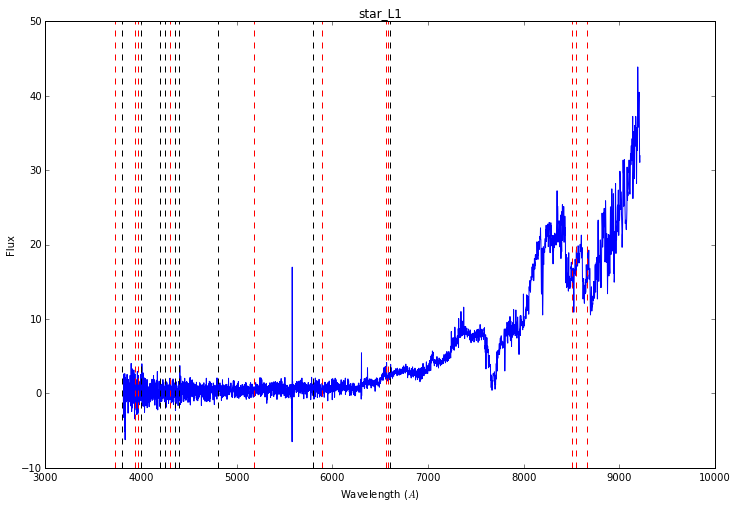

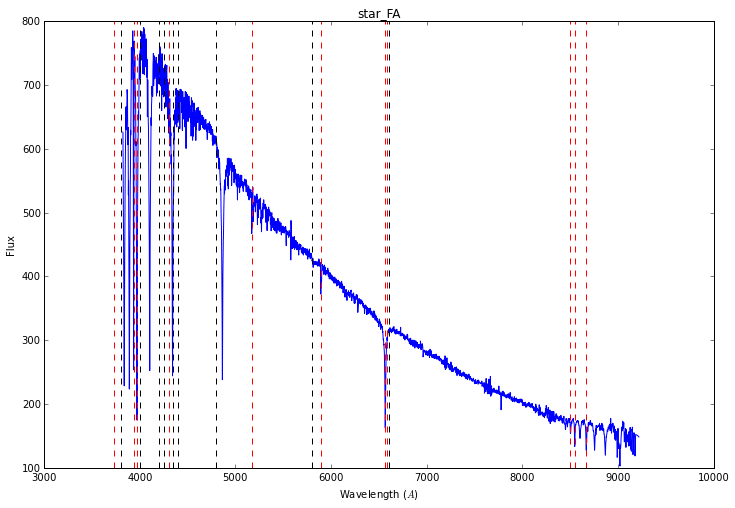

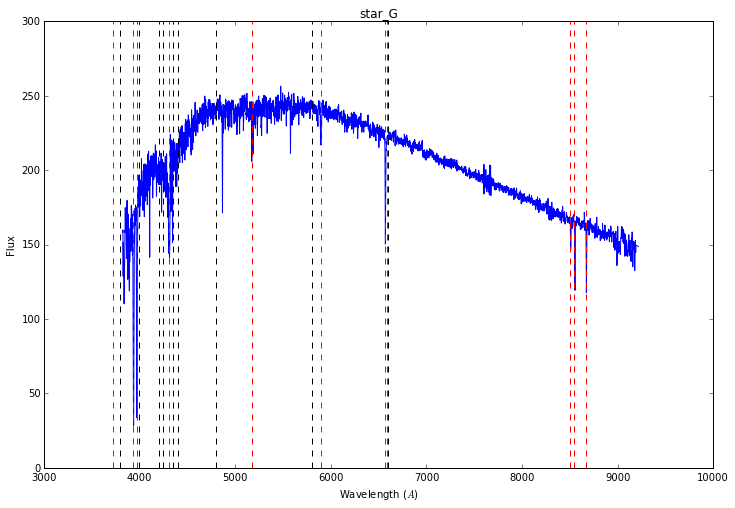

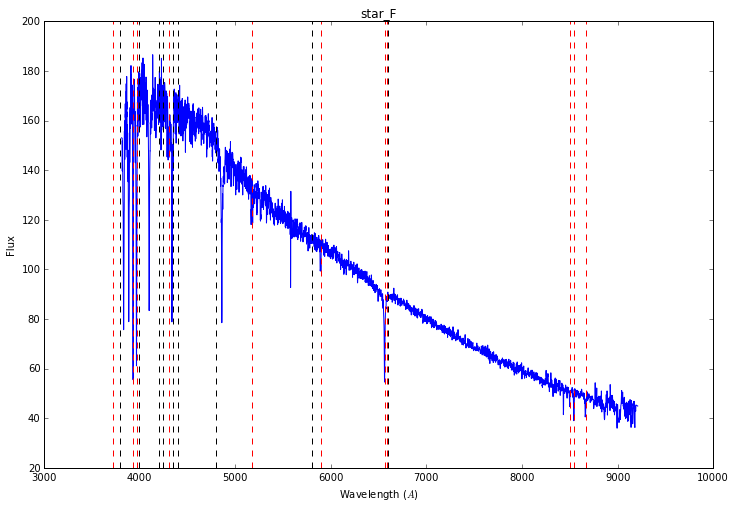

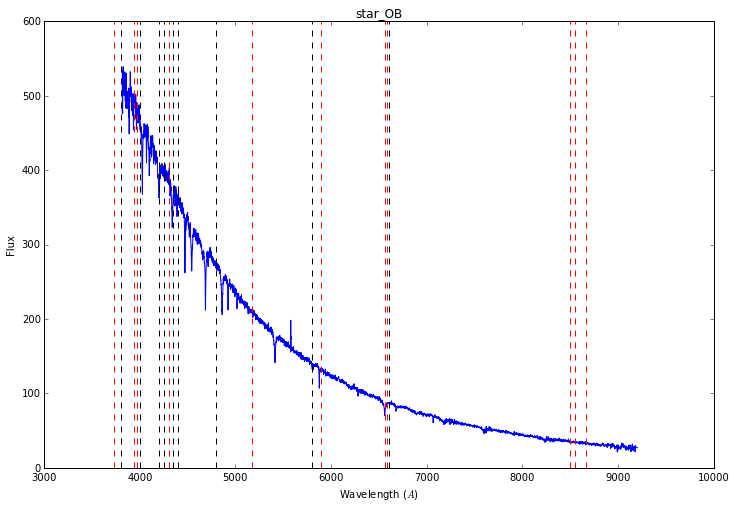

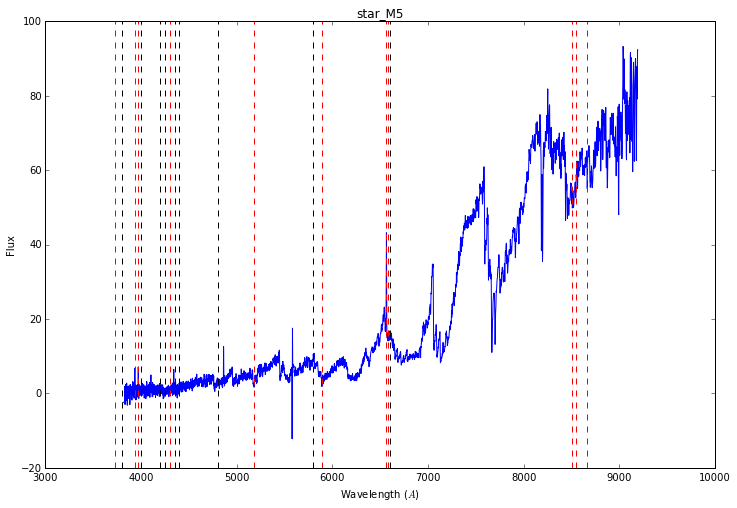

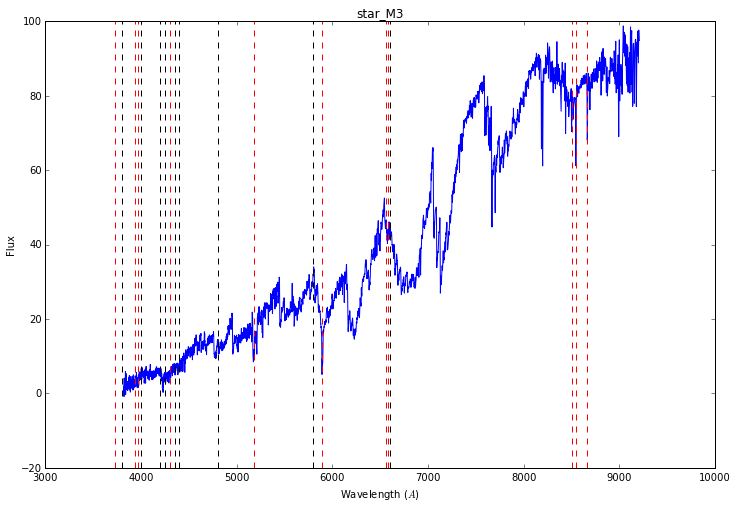

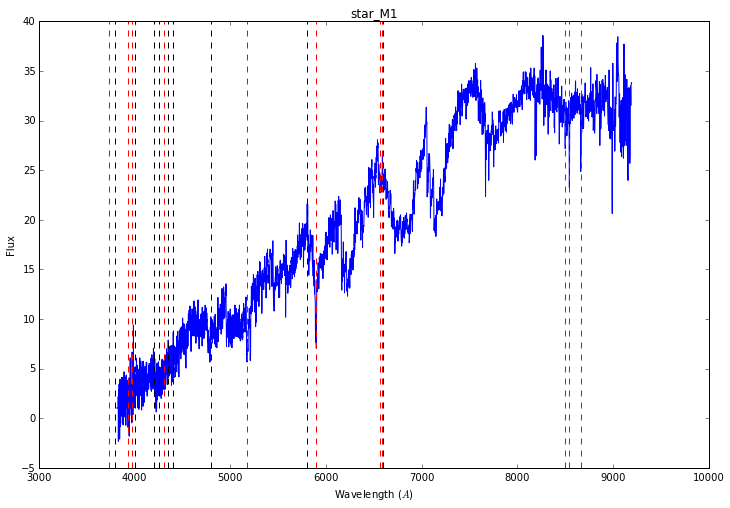

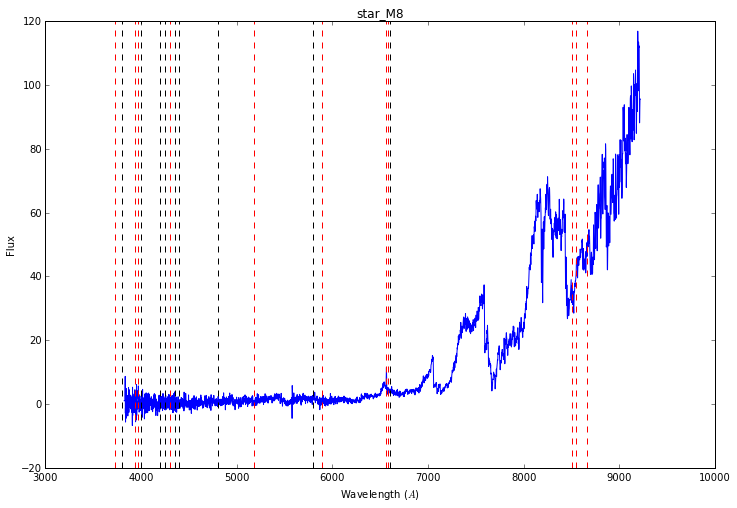

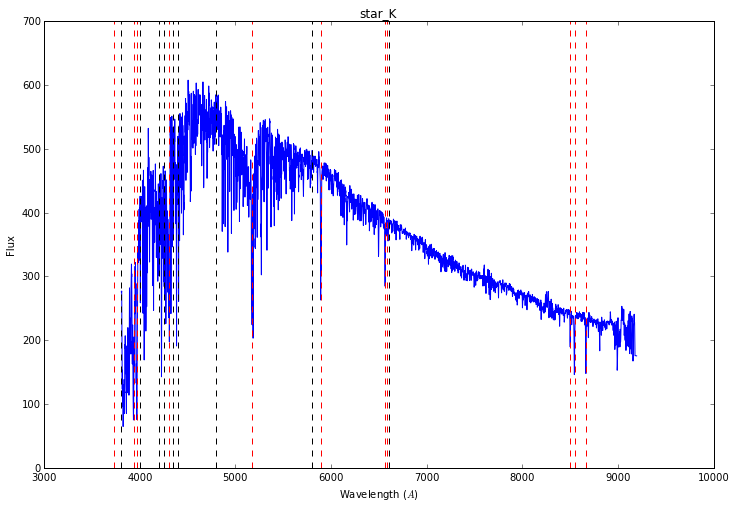

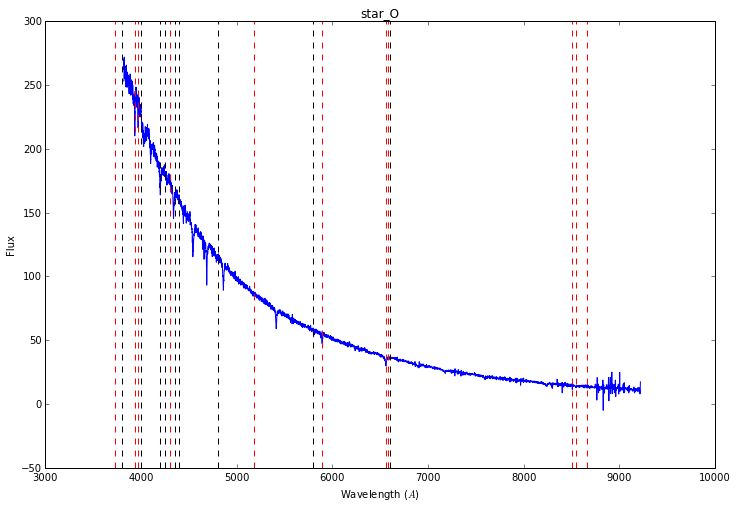

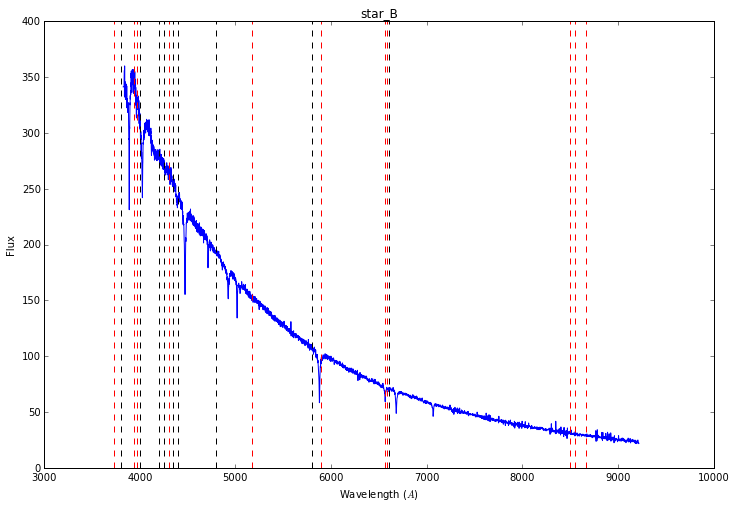

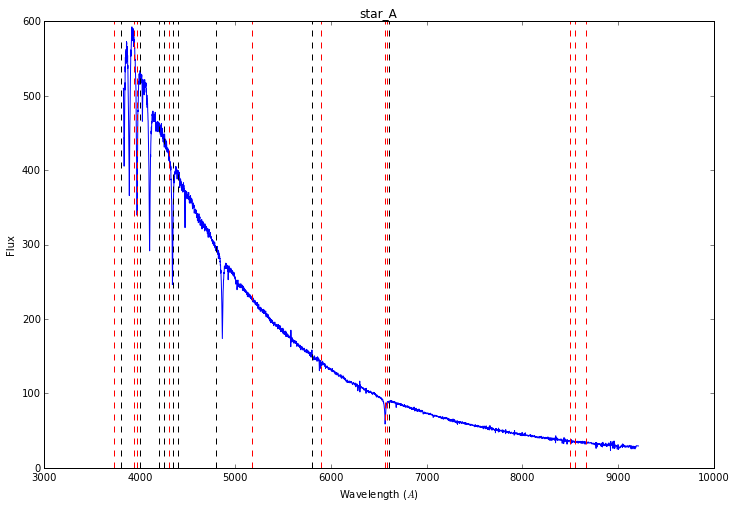

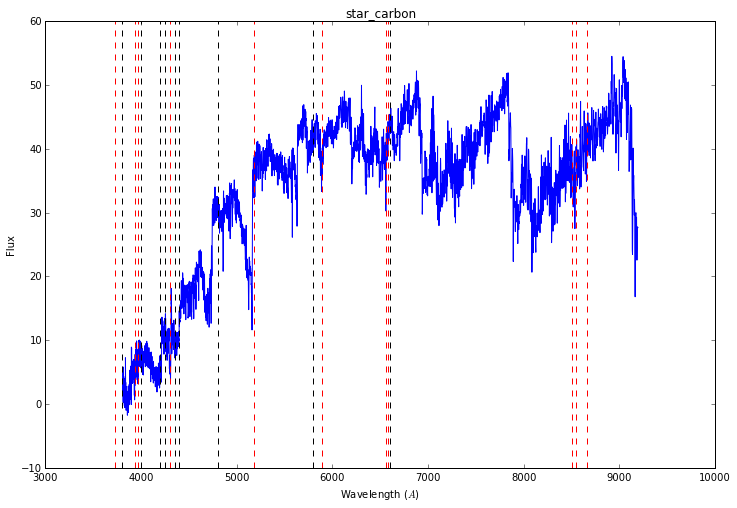

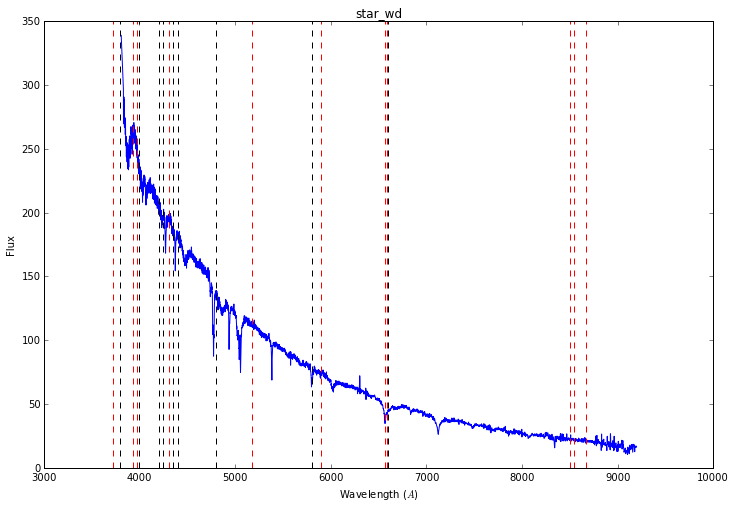

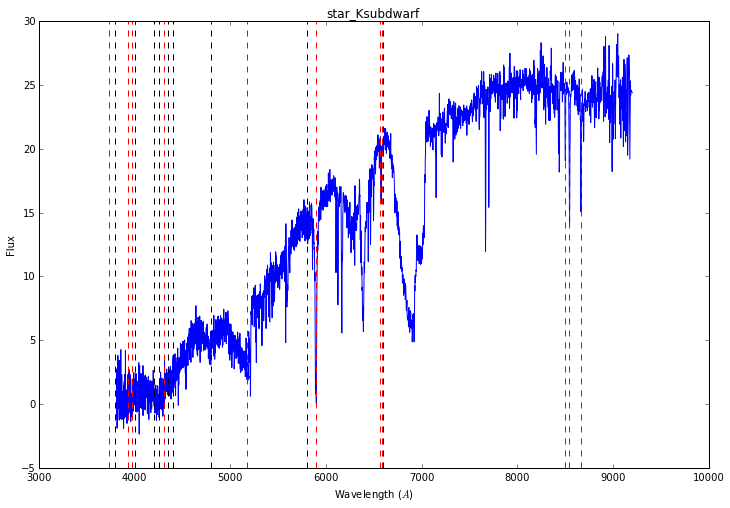

In [37]:
import matplotlib.pyplot as plt
import numpy as np

dashlines=[6600,4800,4350,3800,4000,4250,5800,4200,4400]
dash=[3934.777,3969.588,4305.61 ,5176.7,5895.6,8500.36,8544.44,8664.52 ,3727.092 ,6564.61,6585.27   ]
%matplotlib inline
h=0
plt.rcParams['figure.figsize'] = (12, 8)
for i in result:
    x,y=templ(i)
    plt.plot(x,y)
    plt.xlabel("Wavelength ($A$)")
    plt.ylabel("Flux")
    plt.title(names[h])
    h=h+1
    for l in dashlines:
        plt.axvline(x=l,color='k',ls='dashed')
    for l in dash:
        plt.axvline(x=l,color='r',ls='dashed')
    plt.show()